In [1]:
using Kinbiont
using DifferentialEquations
using CSV
using SymbolicRegression
using Plots
using StatsBase
using Distributions

In this example, we will use Kinbiont to generate data about a single species. We suppose that the growth rate depends on an experimental feature (mu = 1 / (1 + feature)) that the user can tune (make different experiments).
But we suppose that the user does not know how this experimental condition affects the growth rate. Then, we perform the experiment at different conditions and fit the data with a simple model, where the growth rate is an effective parameter fixed by the experimental condition (i.e., mu(feature) -> mu_eff).
Finally, applying symbolic regression on the fitted results, we retrieve the relationship between the experimental feature and the effective growth rate.

In [2]:
# We define the function that alters the growth rate
function unknown_response(feature)
    response = 1 / (1 + feature)
    return response
end

unknown_response (generic function with 1 method)

In [3]:
# Defining the used ODE model
results_fit = Any

Any

In [4]:
ODE_models = "baranyi_richards"

"baranyi_richards"

In [5]:
ub_1 = [0.2, 5.1, 500.0, 5.0]
lb_1 = [0.0001, 0.1, 0.00, 0.2]
p1_guess = lb_1 .+ (ub_1 .- lb_1) ./ 2

4-element Vector{Float64}:
   0.10005000000000001
   2.6
 250.0
   2.6

In [6]:
# Defining the range of the perturbation on feature
feature_range = 0.0:0.4:4.0

0.0:0.4:4.0

In [7]:
# Defining the parameters values for the simulation
p_sim = [0.1, 1.0, 50.0, 1.0]
psim_1_0 = p_sim[1]

0.1

In [8]:
t_min = 0.0
t_max = 800.0
n_start = [0.1]
delta_t = 5.0
noise_value = 0.02

0.02

In [9]:
plot(0, 0)
for f in feature_range
    # Changing the parameters with unknown perturbation
    p_sim[1] = psim_1_0 * unknown_response(f)

    # Calling the simulation function
    sim = Kinbiont.ODE_sim("baranyi_richards", n_start, t_min, t_max, delta_t, p_sim)

    # Adding uniform random noise
    noise_uniform = rand(Uniform(-noise_value, noise_value), length(sim.t))

    data_t = reduce(hcat, sim.t)
    data_o = reduce(hcat, sim.u)
    data_OD = vcat(data_t, data_o)
    data_OD[2, :] = data_OD[2, :] .+ noise_uniform

    # Plotting scatterplot of data with noise
    #display(Plots.scatter!(data_OD[1, :], data_OD[2, :], xlabel="Time", ylabel="Arb. Units", label=nothing, color=:red, markersize=2, size=(300, 300)))

    results_ODE_fit = fitting_one_well_ODE_constrained(
        data_OD,
        string(f),
        "test_ODE",
        "baranyi_richards",
        p1_guess;
        lb=lb_1,
        ub=ub_1
    )

    #display(Plots.plot!(results_ODE_fit[4], results_ODE_fit[3], xlabel="Time", ylabel="Arb. Units", label=nothing, color=:red, markersize=2, size=(300, 300)))

    if f == feature_range[1]
        results_fit = results_ODE_fit[2]
    else
        results_fit = hcat(results_fit, results_ODE_fit[2])
    end
end

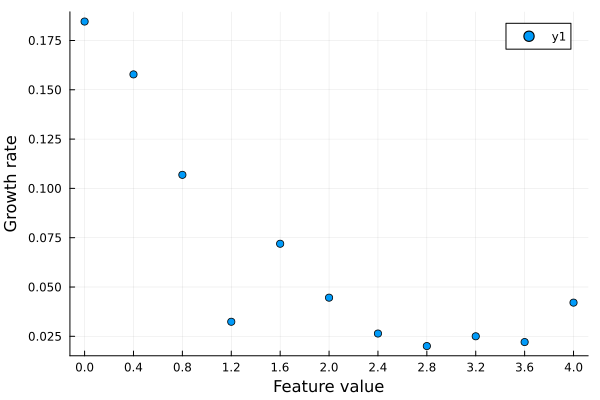

In [10]:
scatter(results_fit[2, :], results_fit[4, :], xlabel="Feature value", ylabel="Growth rate")

In [11]:
# Setting options for symbolic regression
options = SymbolicRegression.Options(
    binary_operators=[+, /, *, -],
    unary_operators=[],
    constraints=nothing,
    elementwise_loss=nothing,
    loss_function=nothing,
    tournament_selection_n=12,
    tournament_selection_p=0.86,
    topn=12,
    complexity_of_operators=nothing,
    complexity_of_constants=nothing,
    complexity_of_variables=nothing,
    parsimony=0.05,
    dimensional_constraint_penalty=nothing,
    alpha=0.100000,
    maxsize=10,
    maxdepth=nothing
)

Options(binops=Function[+, /, *, -], unaops=Function[], bin_constraints=[(-1, -1), (-1, -1), (-1, -1), (-1, -1)], una_constraints=Int64[], complexity_mapping=SymbolicRegression.CoreModule.OptionsStructModule.ComplexityMapping{Int64}(false, Int64[], Int64[], 1, 1), tournament_selection_n=12, tournament_selection_p=0.86, tournament_selection_weights=[0.86, 0.12040000000000001, 0.016856000000000003, 0.0023598400000000006, 0.0003303776000000001, 4.625286400000002e-5, 6.475400960000003e-6, 9.065561344000006e-7, 1.2691785881600008e-7, 1.7768500234240014e-8, 2.4875900327936024e-9, 3.482626045911044e-10], parsimony=0.05, dimensional_constraint_penalty=nothing, alpha=0.1, maxsize=10, maxdepth=10, turbo=false, migration=true, hof_migration=true, should_simplify=true, should_optimize_constants=true, output_file=hall_of_fame_2025-03-24_144731.450.csv, populations=15, perturbation_factor=0.076, annealing=false, batching=false, batch_size=50, mutation_weights=..., crossover_probability=0.066, warmup

In [12]:
# Generating feature matrix
# The first column is the label as a string of the feature value we used for the fitting labeling
feature_matrix = [[string(f), f] for f in feature_range]
feature_matrix = permutedims(reduce(hcat, feature_matrix))

11×2 Matrix{Any}:
 "0.0"  0.0
 "0.4"  0.4
 "0.8"  0.8
 "1.2"  1.2
 "1.6"  1.6
 "2.0"  2.0
 "2.4"  2.4
 "2.8"  2.8
 "3.2"  3.2
 "3.6"  3.6
 "4.0"  4.0

In [13]:
# Symbolic regression between the feature and the growth rate (4th row of the results_fit)
gr_sy_reg = Kinbiont.downstream_symbolic_regression(results_fit, feature_matrix, 4; options=options)

┌ Warning: You are using multithreading mode, but only one thread is available. Try starting julia with `--threads=auto`.
└ @ SymbolicRegression ~/.julia/packages/SymbolicRegression/5HYEt/src/SymbolicRegression.jl:546


Started!


┣                                             ┫ 0/150 [00:00<00:-26, -0s/it]Expressions evaluated per second: [.....]. Head worker occupation: 0.0%         Press 'q' and then <enter> to stop execution early.                             Hall of Fame:                                                                   ---------------------------------------------------------------------------------------------------                                                             Complexity  Loss       Score     Equation                                       1           2.892e-01  3.604e+01  y = 0.60162                                   3           1.159e-02  1.608e+00  y = (-0.042686 * 0.60162)                     5           3.060e-03  6.661e-01  y = ((0.065481 - x₁) + x₁)                    9           3.059e-03  5.144e-05  y = (((-0.042686 * (-0.73644 + -0.8044)) - x₁) + x₁)                                                                          --------------------------------------------

(Node{Float64}[0.06671152160309435, (0.13056050388662332 / (x1 + 0.6643746062370234)), (0.1825593438078684 / ((x1 * x1) + 1.0498940500046898)), (0.22423625025653346 / (1.1597790428836001 + ((x1 - -0.42273611154512836) * x1)))], Any["Complexity" 1 … 7 9; "MSE" 0.0030581411708453642 … 0.00031929167310948224 0.0002944945526283636; "Equation" "0.06671152160309435" … "(0.1825593438078684 / ((x1 * x1) + 1.0498940500046898))" "(0.22423625025653346 / (1.1597790428836001 + ((x1 - -0.42273611154512836) * x1)))"], [0.06671152160309435 0.19651639701599966 0.17388358740298882 0.19334394049663706; 0.06671152160309435 0.12266405372841925 0.15088870286382575 0.15060799466098676; … ; 0.06671152160309435 0.030616565368264573 0.013030744069603244 0.014335862947482056; 0.06671152160309435 0.027990998774421506 0.01070735942830203 0.011895365734191574], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

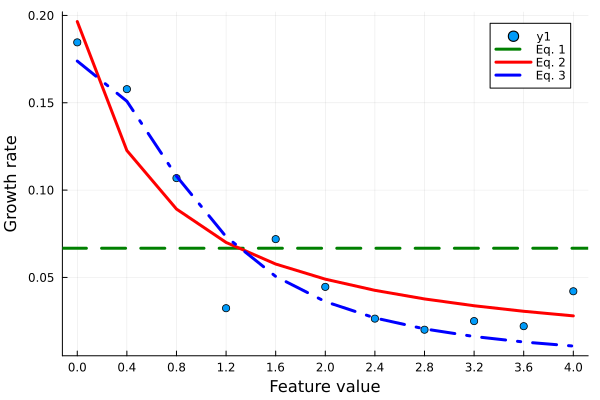

In [15]:
scatter(results_fit[2, :], results_fit[4, :], xlabel="Feature value", ylabel="Growth rate")
hline!(unique(gr_sy_reg[3][:, 1]), label=["Eq. 1" nothing], line=(3, :green, :dash))
plot!(unique(results_fit[2, :]), unique(gr_sy_reg[3][:, 2]), label=["Eq. 2" nothing], line=(3, :red))
plot!(unique(results_fit[2, :]), unique(gr_sy_reg[3][:, 3]), label=["Eq. 3" nothing], line=(3, :blue, :dashdot))
